# 변수 선택(Variable Selection) 기법에 대한 코드

# Quick setup for pySpark

In [ ]:
!pip install pyspark
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# pyspark 모듈 및 sql 라이브러리 설치
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

# 데이터셋 다운로드
본 데이터는 포트투갈 은행의 직접 마케팅 캠페인에 관련된 데이터임. 마케팅 캠페인은 전화에 기반하여 실시되었음. 
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

# 목표: 고객이 정기예금에 가입하였는지 안했는지를 예측하는 것

In [ ]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

In [ ]:
!mkdir data
!unzip bank.zip -d data/

Archive:  bank.zip
  inflating: data/bank-full.csv      
  inflating: data/bank-names.txt     
  inflating: data/bank.csv           


데이터 읽기 및
타겟 변수 (y) 설정: 고객이 정기예금에 가입했는지에 대한 여부 (y/n)

In [ ]:
filename = "data/bank-full.csv"
target_variable_name = "y"

In [ ]:
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df.show()
# df.schema 확인

스키마 출력

In [ ]:
df.printSchema()

education 컬럼의 값을 그룹화하여 갯수를 계산

In [ ]:
df.groupBy('education').count().show()

In [ ]:
df.groupBy(target_variable_name).count().show()

In [ ]:
df.groupBy(['education',target_variable_name]).count().show()

Questions 1. 다수개의 features와 target 값을 group화 한뒤 개수를 출력하시오

In [ ]:
from pyspark.sql.functions import * 
df.groupBy(target_variable_name).agg({'balance':'avg', 'age': 'avg'}).show()

In [ ]:
from pyspark.sql.functions import approxCountDistinct, countDistinct

def cardinality_calculation(df, cut_off=1):
    cardinality = df.select(*[approxCountDistinct(c).alias(c) for c in df.columns])
    
    ## convert to pandas for efficient calculations
    final_cardinality_df = cardinality.toPandas().transpose()
    final_cardinality_df.reset_index(inplace=True) 
    final_cardinality_df.rename(columns={0:'Cardinality'}, inplace=True) 
    
    #select variables with cardinality of 1
    vars_selected = final_cardinality_df['index'][final_cardinality_df['Cardinality'] <= cut_off] 
    
    return final_cardinality_df, vars_selected

cardinality_df, cardinality_vars_selected = cardinality_calculation(df)

In [ ]:
cardinality_df

In [ ]:
from pyspark.sql.functions import count, when, isnan, col

# miss_percentage 80%
def missing_calculation(df, miss_percentage=0.80):
    
    # checks for both NaN and null values
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = df.count()
    ## convert to pandas for efficient calculations
    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True) 
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True) 
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df
    
    #select variables with cardinality of 1
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage] 
    
    return final_missing_df, vars_selected

In [ ]:
df.describe().toPandas()

,summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,None,None,None,None,1362.2720576850766,None,None,None,15.80641879188693,None,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,None,None
2,stddev,10.618762040975408,None,None,None,None,3044.7658291685243,None,None,None,8.322476153044596,None,257.52781226517095,3.098020883279184,100.12874599059813,2.3034410449312204,None,None
3,min,18,admin.,divorced,primary,no,-8019,no,no,cellular,1,apr,0,1,-1,0,failure,no
4,max,95,unknown,single,unknown,yes,102127,yes,yes,unknown,31,sep,4918,63,871,275,unknown,yes


In [ ]:
missing_df, missing_vars_selected = missing_calculation(df)

In [ ]:
missing_df

,index,missing_count,missing_percentage
0,age,0,0.0
1,job,0,0.0
2,marital,0,0.0
3,education,0,0.0
4,default,0,0.0
5,balance,0,0.0
6,housing,0,0.0
7,loan,0,0.0
8,contact,0,0.0
9,day,0,0.0


String 변수를 가진 컬럼을 식별

In [ ]:
def variable_type(df):
    
    vars_list = df.dtypes
    char_vars = []
    num_vars = []
    for i in vars_list:
        if i[1] in ('string'):
            char_vars.append(i[0])
        else:
            num_vars.append(i[0])
    
    return char_vars, num_vars

In [ ]:
char_vars, num_vars = variable_type(df)

In [ ]:
char_vars

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [ ]:
num_vars

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

특정변환기를 선택된 컬럼에 적용

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

def category_to_index(df, char_vars):
    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels

In [ ]:
df, char_labels = category_to_index(df, char_vars)

In [ ]:
df = df.select([c for c in df.columns if c not in char_vars])

In [ ]:
def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

In [ ]:
df = rename_columns(df, char_vars)

In [ ]:
df.dtypes

[('age', 'int'),
 ('balance', 'int'),
 ('day', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('job', 'double'),
 ('marital', 'double'),
 ('education', 'double'),
 ('default', 'double'),
 ('housing', 'double'),
 ('loan', 'double'),
 ('contact', 'double'),
 ('month', 'double'),
 ('poutcome', 'double'),
 ('y', 'double')]

In [ ]:
df.describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,1362.2720576850766,15.80641879188693,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,2.7010240870584594,0.5132379288226316,0.720488376722479,0.018026586450200173,0.44416181902634316,0.16022649355245405,0.4165357988100241,2.4309570679701844,0.29006215301585897,0.11698480458295547
2,stddev,10.618762040975408,3044.7658291685243,8.322476153044596,257.52781226517095,3.098020883279184,100.12874599059813,2.3034410449312204,2.667928848266186,0.6929484478789288,0.8665528095030551,0.1330489390167442,0.49687781026196304,0.3668200383232984,0.6095857052690292,2.494990479670114,0.6984693494366165,0.321405732615664
3,min,18,-8019,1,0,1,-1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,95,102127,31,4918,63,871,275,11.0,2.0,3.0,1.0,1.0,1.0,2.0,11.0,3.0,1.0


특징을 Assemble

In [ ]:
from pyspark.ml.feature import VectorAssembler

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

In [ ]:
#exclude target variable and select all other feature vectors
features_list = df.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove(target_variable_name)

In [ ]:
features_list

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [ ]:
# apply the function on our dataframe
df = assemble_vectors(df, features_list, target_variable_name)

In [ ]:
df.show()

+---+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|  y|            features|age|balance|day|duration|campaign|pdays|previous| job|marital|education|default|housing|loan|contact|month|poutcome|
+---+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|0.0|(16,[0,1,2,3,4,5,...| 58|   2143|  5|     261|       1|   -1|       0| 1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
|0.0|(16,[0,1,2,3,4,5,...| 44|     29|  5|     151|       1|   -1|       0| 2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
|0.0|(16,[0,1,2,3,4,5,...| 33|      2|  5|      76|       1|   -1|       0| 7.0|    0.0|      0.0|    0.0|    0.0| 1.0|    1.0|  0.0|     0.0|
|0.0|(16,[0,1,2,3,4,5,...| 47|   1506|  5|      92|       1|   -1|       0| 0.0|    0.0|      3.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|

In [ ]:
df.schema

StructType(List(StructField(y,DoubleType,false),StructField(features,VectorUDT,true),StructField(age,IntegerType,true),StructField(balance,IntegerType,true),StructField(day,IntegerType,true),StructField(duration,IntegerType,true),StructField(campaign,IntegerType,true),StructField(pdays,IntegerType,true),StructField(previous,IntegerType,true),StructField(job,DoubleType,false),StructField(marital,DoubleType,false),StructField(education,DoubleType,false),StructField(default,DoubleType,false),StructField(housing,DoubleType,false),StructField(loan,DoubleType,false),StructField(contact,DoubleType,false),StructField(month,DoubleType,false),StructField(poutcome,DoubleType,false)))

In [ ]:
df.schema["features"].metadata["ml_attr"]["attrs"]

{'nominal': [{'idx': 7,
   'name': 'job',
   'vals': ['blue-collar',
    'management',
    'technician',
    'admin.',
    'services',
    'retired',
    'self-employed',
    'entrepreneur',
    'unemployed',
    'housemaid',
    'student',
    'unknown',
    '__unknown']},
  {'idx': 8,
   'name': 'marital',
   'vals': ['married', 'single', 'divorced', '__unknown']},
  {'idx': 9,
   'name': 'education',
   'vals': ['secondary', 'tertiary', 'primary', 'unknown', '__unknown']},
  {'idx': 10, 'name': 'default', 'vals': ['no', 'yes', '__unknown']},
  {'idx': 11, 'name': 'housing', 'vals': ['yes', 'no', '__unknown']},
  {'idx': 12, 'name': 'loan', 'vals': ['no', 'yes', '__unknown']},
  {'idx': 13,
   'name': 'contact',
   'vals': ['cellular', 'unknown', 'telephone', '__unknown']},
  {'idx': 14,
   'name': 'month',
   'vals': ['may',
    'jul',
    'aug',
    'jun',
    'nov',
    'apr',
    'feb',
    'jan',
    'oct',
    'sep',
    'mar',
    'dec',
    '__unknown']},
  {'idx': 15,
   'na

In [ ]:
import pandas as pd
features_df = None
for k, v in df.schema["features"].metadata["ml_attr"]["attrs"].items():
    if features_df is None:
      features_df = pd.DataFrame(v)
    else:
      features_df= pd.concat([features_df, pd.DataFrame(v)], axis=0)

In [ ]:
features_df = features_df.loc[:, ['idx', 'name']]
features_df

,idx,name
0,0,age
1,1,balance
2,2,day
3,3,duration
4,4,campaign
5,5,pdays
6,6,previous
0,7,job
1,8,marital
2,9,education


Scaled input vectors assembled

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

#assemble and scale individual columns to one column - 'features2'
def scaled_assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='assembled_features')
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol='features2')
    stages = [assembler, scaler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features2'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    scaleAssembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = scaleAssembleModel.transform(df).select(selectedCols)
    return df

In [ ]:
features_list = df.columns
features_list.remove(target_variable_name)

In [ ]:
df = scaled_assemble_vectors(df, features_list, target_variable_name)

In [ ]:
df.show()

+---+--------------------+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|  y|           features2|            features|age|balance|day|duration|campaign|pdays|previous| job|marital|education|default|housing|loan|contact|month|poutcome|
+---+--------------------+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 58|   2143|  5|     261|       1|   -1|       0| 1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 44|     29|  5|     151|       1|   -1|       0| 2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 33|      2|  5|      76|       1|   -1|       0| 7.0|    0.0|      0.0|    0.0|    0.0| 1.0|    1.0|  0.0|     0.0|
|0.0|(32,[0,1,2,

Built-in Variable Selection Process: Without Target

Principal Component Analysis

In [ ]:
df.describe().toPandas()

,summary,y,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,poutcome
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,0.11698480458295547,40.93621021432837,1362.2720576850766,15.80641879188693,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,2.7010240870584594,0.5132379288226316,0.720488376722479,0.018026586450200173,0.44416181902634316,0.16022649355245405,0.4165357988100241,2.4309570679701844,0.29006215301585897
2,stddev,0.321405732615664,10.618762040975408,3044.7658291685243,8.322476153044596,257.52781226517095,3.098020883279184,100.12874599059813,2.3034410449312204,2.667928848266186,0.6929484478789288,0.8665528095030551,0.1330489390167442,0.49687781026196304,0.3668200383232984,0.6095857052690292,2.494990479670114,0.6984693494366165
3,min,0.0,18,-8019,1,0,1,-1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,1.0,95,102127,31,4918,63,871,275,11.0,2.0,3.0,1.0,1.0,1.0,2.0,11.0,3.0


In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)

result = model.transform(df).select("pcaFeatures")
result.show(truncate=False)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-2143.495364773581,-257.0420740676505,1.2449712753048212]  |
|[-29.29226175164628,-150.92888640669165,1.0493026899279903] |
|[-2.150889773941882,-75.98191250436612,1.0760651955381237]  |
|[-1506.1823305908117,-89.21547154672699,1.2683999536976271] |
|[-1.3750908349448236,-197.9835617549482,0.9892427009816414] |
|[-231.26679712386618,-138.56034919503713,1.0576960891396285]|
|[-447.4072782675641,-216.16541383839743,1.0066666548031231] |
|[-2.712326444744223,-379.97858281643545,0.8751504698368189] |
|[-121.11144848214049,-49.75636025970778,1.172585359192404]  |
|[-593.1146061641075,-53.89364261832033,1.1817022732262128]  |
|[-270.4212341323417,-221.48699661827914,1.0170824073205755] |
|[-390.26081676654087,-136.27016909339133,1.0625336862699843]|
|[-6.967616100129188,-516.9674558248696,0.8003545768071

In [ ]:
model.pc.toArray()

array([[-3.41021399e-04,  2.79524640e-04,  2.58353293e-03],
       [-9.99998245e-01,  1.83654726e-03,  1.13892524e-04],
       [-1.22934480e-05,  9.79995613e-04,  7.79347982e-03],
       [-1.83671689e-03, -9.99996986e-01, -7.36955549e-04],
       [ 1.48468991e-05,  1.01391994e-03,  2.75121381e-03],
       [-1.13085547e-04,  7.49207153e-04, -9.99889046e-01],
       [-1.26153895e-05, -6.36100089e-06, -1.04654388e-02],
       [-1.78789640e-05, -4.11817349e-05,  5.51411389e-04],
       [ 6.41085932e-06, -5.23364803e-05, -1.45349520e-04],
       [-1.11185424e-05,  1.30366514e-05,  2.01500982e-04],
       [ 2.91665702e-06,  4.42643869e-06,  3.95562163e-05],
       [-1.12221341e-05,  1.26153926e-05,  6.17569266e-04],
       [ 1.01623400e-05,  1.50687571e-05,  8.23933054e-05],
       [-5.68377754e-07,  6.95393403e-05,  1.03951369e-03],
       [-7.60886236e-05, -1.16754927e-04, -3.24662847e-03],
       [-8.55162111e-06, -6.01853226e-05, -4.94522998e-03]])

In [ ]:
model.explainedVariance

DenseVector([0.9918, 0.0071, 0.0011])

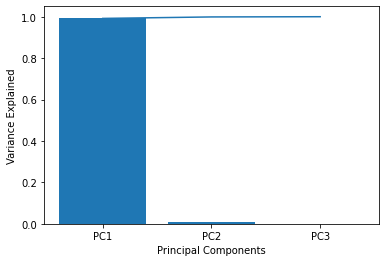

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = []
for i in range(0, len(model.explainedVariance)):
    x.append('PC' + str(i + 1))
y = np.array(model.explainedVariance)
z = np.cumsum(model.explainedVariance)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.bar(x, y)
plt.plot(x, z)

In [ ]:
pca = PCA(k=3, inputCol="features2", outputCol="pcaFeatures")
model = pca.fit(df)

result = model.transform(df).select("pcaFeatures")
result.show(truncate=False)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-0.6567808835228072,4.3121948711553015,-4.3937648469809]   |
|[-0.5905533920179786,2.7430023739115277,-2.0129736282025625]|
|[-0.7923309293106022,2.428517822202711,-1.412875839724541]  |
|[-0.7779852947451491,4.298302632066033,-5.322505502928547]  |
|[-0.5280039534401401,6.559141503669079,-1.4081500208397828] |
|[-0.7028277580737647,2.7093407342344897,-3.226355647066135] |
|[-0.8104872327792136,1.429021001344571,-1.619935441334062]  |
|[-0.9758735335487279,2.862044859015957,0.4335559756415678]  |
|[-0.7126916038562845,5.175637716397523,-4.531453571469944]  |
|[-0.5939132026124012,2.7467852504302592,-2.0709944257197654]|
|[-0.48367202786573626,2.584502296306621,-0.8133472106594244]|
|[-0.5574665926506135,2.079820030407318,-1.1695266299980636] |
|[-0.6052039081600511,3.4943812853193674,-3.06065582479

In [ ]:
model.explainedVariance

DenseVector([0.1434, 0.0987, 0.0787])

Singluar Value Decomposition

In [ ]:
df_svd_vector = df.rdd.map(lambda x: x['features'].toArray())

In [ ]:
df_svd_vector

PythonRDD[208] at RDD at PythonRDD.scala:53

In [ ]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

mat = RowMatrix(df_svd_vector)

# Compute the top 5 singular values and corresponding singular vectors.
svd = mat.computeSVD(5, computeU=True)
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V = svd.V       # The V factor is a local dense matrix.

In [ ]:
U.rows.collect()

[DenseVector([-0.003, 0.0026, 0.0011, 0.0048, 0.0087]),
 DenseVector([-0.0, 0.0021, 0.0005, 0.0049, 0.006]),
 DenseVector([-0.0, 0.001, 0.0002, 0.0042, 0.0039]),
 DenseVector([-0.0021, 0.0006, 0.0004, 0.0053, 0.0066]),
 DenseVector([-0.0, 0.0027, 0.0007, 0.0029, 0.0039]),
 DenseVector([-0.0003, 0.0018, 0.0005, 0.0037, 0.0043]),
 DenseVector([-0.0006, 0.0027, 0.0008, 0.0017, 0.0029]),
 DenseVector([-0.0, 0.0051, 0.0013, 0.0022, 0.0057]),
 DenseVector([-0.0002, 0.0007, 0.0001, 0.008, 0.0088]),
 DenseVector([-0.0008, 0.0005, 0.0002, 0.0056, 0.0058]),
 DenseVector([-0.0004, 0.0029, 0.0008, 0.0036, 0.0055]),
 DenseVector([-0.0006, 0.0017, 0.0005, 0.0028, 0.0031]),
 DenseVector([-0.0, 0.007, 0.0018, 0.0022, 0.0079]),
 DenseVector([-0.0001, 0.001, 0.0001, 0.0078, 0.0088]),
 DenseVector([-0.0002, 0.0023, 0.0005, 0.0065, 0.0086]),
 DenseVector([-0.0003, 0.0047, 0.0012, 0.0036, 0.0075]),
 DenseVector([-0.0, 0.0013, 0.0003, 0.0057, 0.0062]),
 DenseVector([-0.0001, 0.0005, 0.0, 0.008, 0.0086]),
 D

In [ ]:
s

DenseVector([709656.9403, 74266.7144, 22052.8227, 6458.1862, 1846.0544])

In [ ]:
V

DenseMatrix(16, 5, [-0.0053, -0.9994, -0.002, -0.0335, -0.0003, -0.005, -0.0001, -0.0003, ..., -0.0064, 0.0045, -0.0003, 0.0016, -0.0013, 0.0028, 0.0086, 0.0011], 0)

Chi-Square selector

In [ ]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

selector = ChiSqSelector(numTopFeatures=6, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="y")

chi_selector = selector.fit(df)
    
result = chi_selector.transform(df)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
print("Selected Indices: ", chi_selector.selectedFeatures)
result.show()

ChiSqSelector output with top 6 features selected
Selected Indices:  [0, 1, 2, 3, 4, 5]
+---+--------------------+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+--------------------+
|  y|           features2|            features|age|balance|day|duration|campaign|pdays|previous| job|marital|education|default|housing|loan|contact|month|poutcome|    selectedFeatures|
+---+--------------------+--------------------+---+-------+---+--------+--------+-----+--------+----+-------+---------+-------+-------+----+-------+-----+--------+--------------------+
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 58|   2143|  5|     261|       1|   -1|       0| 1.0|    0.0|      1.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|(6,[0,1,2,3,4,5],...|
|0.0|(32,[0,1,2,3,4,5,...|(16,[0,1,2,3,4,5,...| 44|     29|  5|     151|       1|   -1|       0| 2.0|    1.0|      0.0|    0.0|    0.0| 0.0|    1.0|  0.0|     0.0|(6,[0,1,2

In [ ]:
features_df['chisq_importance'] = features_df['idx'].apply(lambda x: 1 if x in chi_selector.selectedFeatures else 0)

In [ ]:
features_df

,idx,name,chisq_importance
0,0,age,1
1,1,balance,1
2,2,day,1
3,3,duration,1
4,4,campaign,1
5,5,pdays,1
6,6,previous,0
0,7,job,0
1,8,marital,0
2,9,education,0


Model-based Feature Selection

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol=target_variable_name)
rf_model = rf.fit(df)
rf_model.featureImportances

SparseVector(16, {0: 0.0321, 1: 0.0021, 2: 0.0061, 3: 0.453, 4: 0.0031, 5: 0.0129, 6: 0.0437, 7: 0.0165, 8: 0.0031, 9: 0.0049, 10: 0.0, 11: 0.0241, 12: 0.0025, 13: 0.022, 14: 0.1248, 15: 0.2492})

In [ ]:
#temporary output rf_output
rf_output = rf_model.featureImportances
features_df['Importance'] = features_df['idx'].apply(lambda x: rf_output[x] if x in rf_output.indices else 0)

In [ ]:
#sort values based on descending importance feature
features_df.sort_values("Importance", ascending=False, inplace=True)

In [ ]:
features_df

,idx,name,chisq_importance,Importance
3,3,duration,1,0.453019
8,15,poutcome,0,0.249233
7,14,month,0,0.124839
6,6,previous,0,0.043690
0,0,age,1,0.032062
4,11,housing,0,0.024059
6,13,contact,0,0.021951
0,7,job,0,0.016516
5,5,pdays,1,0.012909
2,2,day,1,0.006084


Text(0, 0.5, 'Variable Importance')

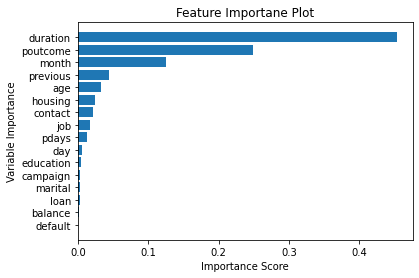

In [ ]:
import matplotlib.pyplot as plt

features_df.sort_values("Importance", ascending=True, inplace=True)
plt.barh(features_df['name'], features_df['Importance'])
plt.title("Feature Importane Plot")
plt.xlabel("Importance Score")
plt.ylabel("Variable Importance")

# Custom-built Variable Selection Process

Information Value using weight of evidence

Correlation

In [ ]:
from pyspark.mllib.stat import Statistics

correlation_type = 'pearson' # 'pearson', 'spearman'

In [ ]:
features_df = None
for k, v in df.schema["features"].metadata["ml_attr"]["attrs"].items():
    if features_df is None:
      features_df = pd.DataFrame(v)
    else:
      features_df= pd.concat([features_df, pd.DataFrame(v)], axis=0)

column_names = list(features_df['name'])

In [ ]:
column_names

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [ ]:
df_vector = df.rdd.map(lambda x: x['features'].toArray())

In [ ]:
matrix = Statistics.corr(df_vector, method=correlation_type)

In [ ]:
corr_df = pd.DataFrame(matrix, columns=column_names, index=column_names)
corr_df

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,poutcome
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.077468,-0.126351,0.167296,-0.017879,0.185513,-0.015655,0.122114,0.089717,0.012238
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,0.020404,-0.028172,0.039067,-0.066745,0.068768,-0.084350,0.002844,0.092853,0.037272
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.010874,-0.005217,-0.004675,0.009424,0.027982,0.011370,-0.006302,-0.038019,-0.072629
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.004410,0.018834,-0.003029,-0.010021,-0.005075,-0.012412,-0.029350,0.014097,0.023192
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.025450,-0.029294,0.018643,0.016822,0.023599,0.009980,0.046971,-0.093829,-0.094982
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,-0.020621,0.020832,-0.023103,-0.029979,-0.124178,-0.022754,-0.170654,0.130504,0.709008
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,-0.002425,0.006876,-0.007463,-0.018329,-0.037076,-0.011043,-0.091911,0.124014,0.485040
job,0.077468,0.020404,-0.010874,0.004410,-0.025450,-0.020621,-0.002425,1.000000,0.050184,-0.002546,-0.003261,0.175678,-0.035331,0.011959,0.116516,0.022384
marital,-0.126351,-0.028172,-0.005217,0.018834,-0.029294,0.020832,0.006876,0.050184,1.000000,-0.061597,0.018404,0.011671,-0.018526,-0.038869,0.010914,0.020126
education,0.167296,0.039067,-0.004675,-0.003029,0.018643,-0.023103,-0.007463,-0.002546,-0.061597,1.000000,-0.007520,0.076023,-0.068765,0.062967,0.028758,-0.010689


In [ ]:
final_corr_df = pd.DataFrame(corr_df.abs().unstack().sort_values(kind='quicksort')).reset_index()
final_corr_df.rename({'level_0': 'col1', 'level_1': 'col2', 0: 'correlation_value'}, axis=1, inplace=True)
final_corr_df = final_corr_df[final_corr_df['col1'] != final_corr_df['col2']]
final_corr_df

,col1,col2,correlation_value
0,housing,poutcome,0.000527
1,poutcome,housing,0.000527
2,default,contact,0.000961
3,contact,default,0.000961
4,duration,previous,0.001203
...,...,...,...
235,previous,pdays,0.454820
236,poutcome,previous,0.485040
237,previous,poutcome,0.485040
238,poutcome,pdays,0.709008


In [ ]:
column_names

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

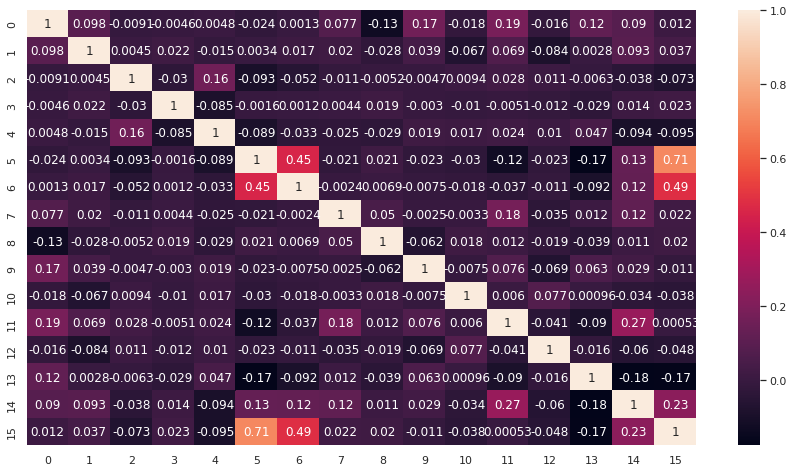

In [ ]:
import seaborn as sns

#ploting the heatmap for correlation
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(matrix, annot=True)

In [ ]:
correlation_cutoff = 0.65 #custom parameter
final_corr_df[final_corr_df['correlation_value'] > correlation_cutoff]

,col1,col2,correlation_value
238,poutcome,pdays,0.709008
239,pdays,poutcome,0.709008


In [ ]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol
from pyspark.mllib.stat import Statistics

class CustomCorrelation(Transformer, HasInputCol):
    """
    A custom function to calculate the correlation between two variables.
    
    Parameters:
    -----------
    inputCol: default value (None)
        Feature column name to be used for the correlation purpose. The input column should be assembled vector.
        
    correlation_type: 'pearson' or 'spearman'
    
    correlation_cutoff: float, default value (0.7), accepted values 0 to 1
        Columns more than the specified cutoff will be displayed in the output dataframe. 
    """
    
    # Initialize parameters for the function
    def __init__(self, inputCol=None, correlation_type='pearson', correlation_cutoff=0.7):
        
        super(CustomCorrelation, self).__init__()
        
        assert inputCol, "Please provide a assembled feature column name"
        
        #self.inputCol is class parameter
        self.inputCol = inputCol         
        assert correlation_type == 'pearson' or correlation_type == 'spearman', "Please provide \
                                a valid option for correlation type. 'pearson' or 'spearman'. "
        
        #self.correlation_type is class parameter
        self.correlation_type = correlation_type
        assert 0.0 <= correlation_cutoff <= 1.0, "Provide a valid value for cutoff. Accepted range is 0 to 1" 
        
        #self.correlation_cutoff is class parameter
        self.correlation_cutoff = correlation_cutoff

    
    # Transformer function, method inside a class, '_transform' - protected parameter
    def _transform(self, df):
        features_df = None
        for k, v in df.schema["features"].metadata["ml_attr"]["attrs"].items():
            if features_df is None:
              features_df = pd.DataFrame(v)
            else:
              features_df= pd.concat([features_df, pd.DataFrame(v)], axis=0)
            
        #self.column_names is class parameter, created for future use
        self.column_names = list(features_df['name'])
        
        df_vector = df.rdd.map(lambda x: x[self.inputCol].toArray())
        matrix = Statistics.corr(df_vector, method=self.correlation_type)
        
        # apply pandas dataframe operation on the fit output
        corr_df = pd.DataFrame(matrix, columns=self.column_names, index=self.column_names)

        final_corr_df = pd.DataFrame(corr_df.abs().unstack().sort_values(kind='quicksort')).reset_index()
        final_corr_df.rename({'level_0': 'col1', 'level_1': 'col2', 0: 'correlation_value'}, axis=1, inplace=True)
        final_corr_df = final_corr_df[final_corr_df['col1'] != final_corr_df['col2']]
        
        #shortlisted dataframe based on custom cutoff
        shortlisted_corr_df = final_corr_df[final_corr_df['correlation_value'] > self.correlation_cutoff]

        return corr_df, shortlisted_corr_df

In [ ]:
clf = CustomCorrelation(inputCol='features')
output, shorlisted_output = clf.transform(df)

In [ ]:
output

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,poutcome
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.077468,-0.126351,0.167296,-0.017879,0.185513,-0.015655,0.122114,0.089717,0.012238
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,0.020404,-0.028172,0.039067,-0.066745,0.068768,-0.084350,0.002844,0.092853,0.037272
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.010874,-0.005217,-0.004675,0.009424,0.027982,0.011370,-0.006302,-0.038019,-0.072629
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.004410,0.018834,-0.003029,-0.010021,-0.005075,-0.012412,-0.029350,0.014097,0.023192
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.025450,-0.029294,0.018643,0.016822,0.023599,0.009980,0.046971,-0.093829,-0.094982
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,-0.020621,0.020832,-0.023103,-0.029979,-0.124178,-0.022754,-0.170654,0.130504,0.709008
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,-0.002425,0.006876,-0.007463,-0.018329,-0.037076,-0.011043,-0.091911,0.124014,0.485040
job,0.077468,0.020404,-0.010874,0.004410,-0.025450,-0.020621,-0.002425,1.000000,0.050184,-0.002546,-0.003261,0.175678,-0.035331,0.011959,0.116516,0.022384
marital,-0.126351,-0.028172,-0.005217,0.018834,-0.029294,0.020832,0.006876,0.050184,1.000000,-0.061597,0.018404,0.011671,-0.018526,-0.038869,0.010914,0.020126
education,0.167296,0.039067,-0.004675,-0.003029,0.018643,-0.023103,-0.007463,-0.002546,-0.061597,1.000000,-0.007520,0.076023,-0.068765,0.062967,0.028758,-0.010689


In [ ]:
shorlisted_output

,col1,col2,correlation_value
238,poutcome,pdays,0.709008
239,pdays,poutcome,0.709008


# Voting-based Selection

In [ ]:
# decision tree
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol=target_variable_name)
dt_model = dt.fit(df)
dt_output = dt_model.featureImportances
features_df['Decision Tree'] = features_df['idx'].apply(lambda x: dt_output[x] if x in dt_output.indices else 0)

In [ ]:
# Gradient boosting
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol='features', labelCol=target_variable_name)
gb_model = gb.fit(df)
gb_output = gb_model.featureImportances
features_df['Gradient Boosting'] = features_df['idx'].apply(lambda x: gb_output[x] if x in gb_output.indices else 0)

In [ ]:
# Random forest
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol=target_variable_name)
rf_model = rf.fit(df)
rf_output = rf_model.featureImportances
features_df['Random Forest'] = features_df['idx'].apply(lambda x: rf_output[x] if x in rf_output.indices else 0)

In [ ]:
features_df.drop(columns=['idx'], axis=1, inplace=True)

In [ ]:
# Voting-based selection
num_top_features = 7
columns = ['Decision Tree', 'Gradient Boosting', 'Random Forest']
score_table = pd.DataFrame({},[])
score_table['name'] = features_df['name']
for i in columns:
  score_table[i] = features_df['name'].isin(list(features_df.nlargest(num_top_features,i)['name'])).astype(int)

score_table['final_score'] = score_table.sum(axis=1)
score_table.sort_values('final_score', ascending=0)

,name,Decision Tree,Gradient Boosting,Random Forest,final_score
3,duration,1,1,1,3
4,housing,1,1,1,3
6,contact,1,1,1,3
7,month,1,1,1,3
8,poutcome,1,1,1,3
2,day,1,1,0,2
0,age,0,0,1,1
1,balance,1,0,0,1
5,pdays,0,1,0,1
6,previous,0,0,1,1


# Pipeline Compatiability for custom Transformers

In [ ]:
# features 컬럼을 삭제.
df = df.drop('features')

In [ ]:
#exclude target variable and select all other feature vectors
features_list = df.columns
features_list.remove(target_variable_name)

In [ ]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml import Pipeline

stages = []

# assemble vectors
assembler = VectorAssembler(inputCols=features_list, outputCol='features')
custom_corr = CustomCorrelation(inputCol=assembler.getOutputCol())
stages = [assembler, custom_corr]

In [ ]:
#use pipeline to process sequentially
pipeline = Pipeline(stages=stages)

In [ ]:
#pipeline model
pipelineModel = pipeline.fit(df)

In [ ]:
#apply pipeline model on data
output, shorlisted_output = pipelineModel.transform(df)

In [ ]:
shorlisted_output

,col1,col2,correlation_value
2142,features2_15,pdays,0.709008
2143,pdays,features2_15,0.709008
2144,features2_31,pdays,0.709008
2145,pdays,features2_31,0.709008
2146,features2_5,features2_31,0.709008
...,...,...,...
2299,poutcome,features2_15,1.000000
2300,features2_27,housing,1.000000
2301,housing,features2_11,1.000000
2302,features2_11,housing,1.000000
